In [ ]:
%load_ext autoreload
%autoreload 2

In [23]:
import sys
sys.path.append('../')
import tokamakTK
from tokamakTK import MyCounter, HUEOrder

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import matplotlib.patches as mpatches
import seaborn as sns

from collections import Counter

def min_max_date(data_):
    dates = sorted(data2_64.DATE.astype(str).values)
    d0 = dates[0]; d1 = dates[-1]
    d0 = d0[:4] + "/" + d0[4:6] + "/" + d0[6:]
    d1 = d1[:4] + "/" + d1[4:6] + "/" + d1[6:]
    return (d0,d1)

pd.set_option('display.max_columns', None)
#plt.rc('font',family = 'serif')
colors_ = sns.color_palette('viridis', 20)
path = "../data/"
fig_path = "../../../LATEX/Latex Images/"

In [2]:
# Obtained from Optimization

min_subset_ids_6357 = pd.read_csv(path+"R_ids_alpha_0.6357.csv")
min_subset_ids_9998 = pd.read_csv(path+"R_ids_alpha_0.9998.csv")
min_subset_ids_joe  = pd.read_csv(path+"deviation_id.csv")

DB2 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"SELDB5_SVD.csv", low_memory=False) 

# Setting ELMy Dataset
DB5 = DB5[DB5["PHASE"].isin(['HGELM', 'HSELM', 'HGELMH', 'HSELMH'])]

# Removing Spherical tokamak_64S
#DB5 = DB5[~DB5["TOK"].isin(['START','MAST','NSTX'])]

# There is two shots from DB2P8 missing in DB5
missing_shots = DB2[~DB2.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

# Labeling shots that had great impact in decreasing alpha_R
DB5.insert(loc=2,column="label_6357",value=["Unaffected"]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids_6357.id)].index), "label_6357"] = "Decreasing"

DB5.insert(loc=2,column="label_9998",value=["Unaffected"]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids_9998.id)].index), "label_9998"] = "Decreasing"

DB5.insert(loc=2,column="label_joe",value=["Unaffected"]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids_joe.id)].index), "label_joe"] = "Decreasing"

DB5.insert(0, 'intercept', np.ones(len(DB5)))


print(
    "  Subset that decrease alpha-R to 0.6357\n--------\n" +
    f"{ round( (len(min_subset_ids_6357)/len(DB5))*100     ,2)  }% affected alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids_6357)/len(DB5))*100 ,2)  }% did not affect alpha_R" +
    "\n\n\n  Subset that decrease alpha-R to 0.9998\n--------\n" +
    f"{ round( (len(min_subset_ids_9998)/len(DB5))*100     ,2)  }% affected alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids_9998)/len(DB5))*100 ,2)  }% did not affect alpha_R"
    "\n\n\n  Subset given by Joseph Hall           \n--------\n" +
    f"{ round( (len(min_subset_ids_joe)/len(DB5))*100     ,2)  }% affected alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids_joe)/len(DB5))*100 ,2)  }% did not affect alpha_R"
)

  Subset that decrease alpha-R to 0.6357
--------
23.45% affected alpha_R
76.55% did not affect alpha_R


  Subset that decrease alpha-R to 0.9998
--------
9.88% affected alpha_R
90.12% did not affect alpha_R


  Subset given by Joseph Hall           
--------
18.46% affected alpha_R
81.54% did not affect alpha_R


In [3]:
features = ['TAUTH','NEL','TAV','BT','RHOSTAR','NUSTAR','BETASTAR']

DB5 = tokamakTK.clean_categorical_data(DB5)

In [4]:
data1_64 = DB5[DB5.label_6357.isin(["Decreasing"])].reset_index(drop=True)
data2_64 = DB5[DB5.label_6357.isin(["Unaffected"])]

data1_99 = DB5[DB5.label_9998.isin(["Decreasing"])].reset_index(drop=True)
data2_99 = DB5[DB5.label_9998.isin(["Unaffected"])]

In [5]:
#tokamakTK.get_regression(data1_64, DB2)[1].summary()

In [6]:
tokamak_64 = pd.DataFrame([
    data1_64["TOK"].value_counts(),
    data2_64["TOK"].value_counts()
    ], index=["data1_64","data2_64"]
).T.fillna(0.0)
tokamak_64 = tokamak_64.sort_values("data2_64", ascending=False)
tokamak_64 = (tokamak_64/len(DB5))*100

In [7]:
tokamak_99 = pd.DataFrame([
    data1_99["TOK"].value_counts(),
    data2_99["TOK"].value_counts()
    ], index=["data1_99","data2_99"]
).T.fillna(0.0)
tokamak_99 = tokamak_99.sort_values("data2_99", ascending=False)
tokamak_99 = (tokamak_99/len(DB5))*100

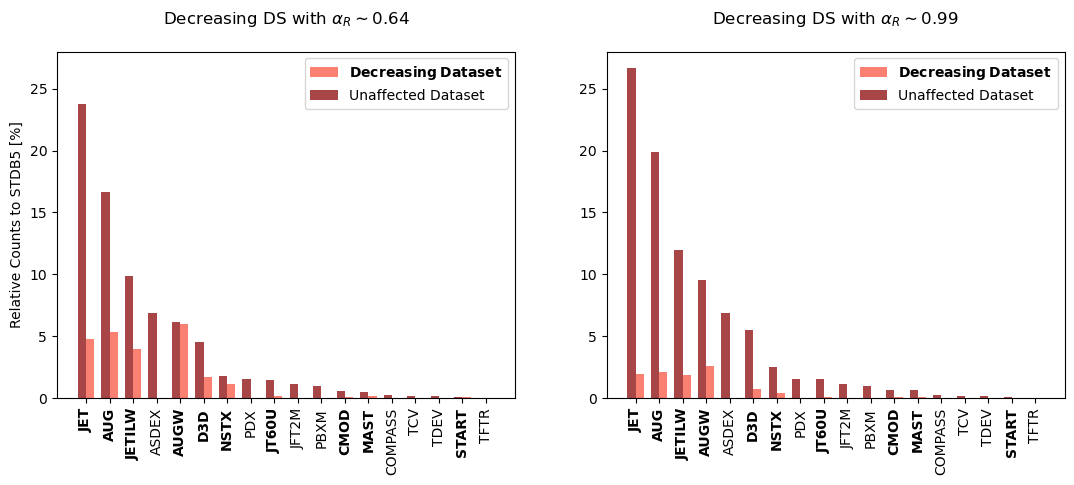

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4.5))

c1="salmon"
c2="#A84547"

# define the x and y values for the bars
x = np.arange(len(tokamak_64.index))
width = 0.35
ax[0].bar(x + width/2, tokamak_64['data1_64'], width, color=c1, label='$\\bf{Decreasing}\\:\\bf{Dataset}$')
ax[0].bar(x - width/2, tokamak_64['data2_64'], width, color=c2, label='Unaffected Dataset')


# set the x-ax[0]is tick labels
ax[0].set_xticks(x)
ax[0].set_xticklabels(tokamak_64.index, rotation=90)

# Set the font weight of 'AUG' and 'MAST' to bold
for label in ax[0].xaxis.get_ticklabels():
    if label.get_text() in data1_64.TOK.unique():
        label.set_fontweight('bold')

# set the y-ax[0]is label
ax[0].set_ylabel('Relative Counts to STDB5 [%]')

# set the plot title and legend
#ax[0].set_title('NEW SHOTS IN STDB5')
ax[0].legend()


# define the x and y values for the bars
x = np.arange(len(tokamak_99.index))
width = 0.35
ax[1].bar(x + width/2, tokamak_99['data1_99'], width, color=c1, label='$\\bf{Decreasing}\\:\\bf{Dataset}$')
ax[1].bar(x - width/2, tokamak_99['data2_99'], width, color=c2, label='Unaffected Dataset')


# set the x-ax[1]is tick labels
ax[1].set_xticks(x)
ax[1].set_xticklabels(tokamak_99.index, rotation=90)

# Set the font weight of 'AUG' and 'MAST' to bold
for label in ax[1].xaxis.get_ticklabels():
    if label.get_text() in data1_99.TOK.unique():
        label.set_fontweight('bold')

# set the y-ax[1]is label
#ax[1].set_ylabel('Relative Counts to STDB5 [%]')

ax[1-1].set_ylim(0, 28)
ax[2-1].set_ylim(0, 28)

# set the plot title and legend
ax[0].set_title('Decreasing DS with $\\alpha_R \\sim 0.64$\n')
ax[1].set_title('Decreasing DS with $\\alpha_R \\sim 0.99$\n')
ax[1].legend()

# display the plot
#plt.savefig(fig_path+"bar_comparsion.pdf", format="pdf", dpi=800, bbox_inches='tight');
plt.show()

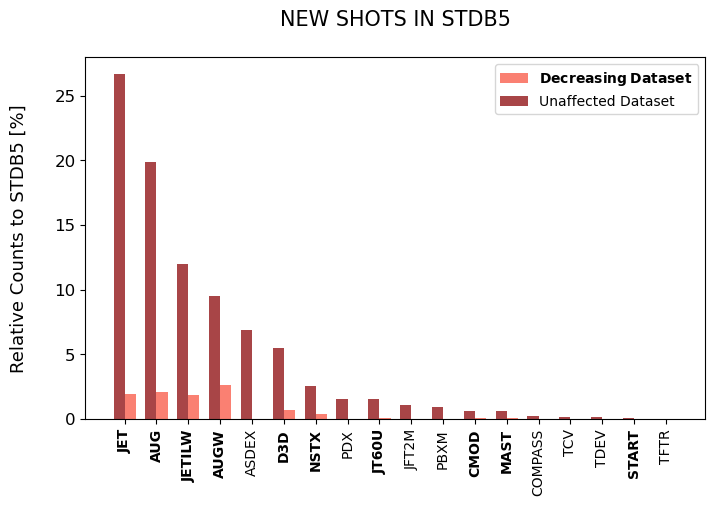

In [21]:
tokamakTK.plot_tok_comparison(data1_99, data2_99, DB5)

In [ ]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Define the x and y values for the bars
x = np.arange(len(tokamak_64.index))
width = 0.35

# Plot data1_64 in the first subplot (axs[0])
axs[0].bar(x + width/2, tokamak_64['data1_64'], width, color='salmon', label='$\\bf{Decreasing}\\:\\bf{Dataset}$')
axs[0].set_xticks(x)
axs[0].set_xticklabels(tokamak_64.index, rotation=90)

# Set the font weight of 'AUG' and 'MAST' to bold in the first subplot
for label in axs[0].xaxis.get_ticklabels():
    if label.get_text() in data1_64.TOK.unique():
        label.set_fontweight('bold')

axs[0].set_ylabel('Relative Counts to STDB5 [%]')
axs[0].set_title('data1_64')
axs[0].legend()

# Plot data2_64 in the second subplot (axs[1])
axs[1].bar(x - width/2, tokamak_64['data2_64'], width, color='#A84547', label='Unaffected Dataset')
axs[1].set_xticks(x)
axs[1].set_xticklabels(tokamak_64.index, rotation=90)

# Set the font weight of 'AUG' and 'MAST' to bold in the second subplot
for label in axs[1].xaxis.get_ticklabels():
    if label.get_text() in data1_64.TOK.unique():
        label.set_fontweight('bold')

axs[1].set_ylabel('Relative Counts to STDB5 [%]')
axs[1].set_title('data2_64')
axs[1].legend()